In [1]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import json
import os
import glob
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from conf_dict_util import conf_to_dict, dict_to_conf
from qoe_utils import make_bandwidth_series, get_QoE_rr, get_QoE_delay, get_QoE_losses, get_reward

In [2]:
# from matplotlib import rcParams
# #IEEE Times New Roman (Nimbus Roman)
# rcParams['text.latex.preamble'] = r"\usepackage{mathptmx}"

# #Latex in general
# rcParams['font.family'] = "serif"
# rcParams['font.serif'] = ['Computer Modern']
# rcParams['text.usetex'] = True

In [3]:
traces = [
'WIRED_200kbps',
'WIRED_900kbps',
'WIRED_35mbps',
'4G_500kbps',
'4G_700kbps',
'4G_3mbps',
'5G_12mbps',
'5G_13mbps',
'trace_300k']

In [4]:
from best_algs import best_models_dict
list_conf_names = [d[200] for d in best_models_dict.values()]
print("Len list_conf_names: ", len(list_conf_names)) 

Len list_conf_names:  9


In [5]:
list_conf_names

['SAC_WIRED_900kbps_200_delay_True_norm_states_True_tuned_True_reward_profile_0_seed_22',
 'TD3_WIRED_200kbps_200_delay_False_norm_states_True_tuned_False_reward_profile_0_seed_22',
 'TD3_WIRED_35mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22',
 'TD3_4G_700kbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22',
 'SAC_4G_3mbps_200_delay_True_norm_states_True_tuned_True_reward_profile_0_seed_22',
 'TD3_4G_500kbps_200_delay_True_norm_states_True_tuned_True_reward_profile_0_seed_22',
 'TD3_5G_12mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22',
 'TD3_5G_13mbps_200_delay_False_norm_states_True_tuned_False_reward_profile_0_seed_22',
 'TD3_trace_300k_200_delay_True_norm_states_True_tuned_True_reward_profile_0_seed_22']

In [6]:
plot_rr = False
plot_delay = False

prefix = "../output_mp/rates_delay_loss_"
suffix = ".pickle"
result_qoe = []


for conf_name in list_conf_names:
    

    d = conf_to_dict(conf_name)
    
    print("Input model: ", conf_name, " trained on trace: ", d["trace_name"])

    time_step = d["step_time"]
    reward_profile = d["reward_profile"]
    delay_states = d["delay_states"]
    normalize_states = d["normalize_states"]
    alg_name = d["alg"]

    dict_result = {}
    name = d["trace_name"]
    REAL_NAME = d["trace_name"]

    #Read rates_delay_loss and make l_rate
    pickle_path = prefix+conf_name+suffix
    if not os.path.exists(pickle_path):
        print("Conf doesn't exist: ", conf_name)
        print("--------------------------")
        continue
    
    l_rate = pd.read_pickle(pickle_path)

    pickle_path_gcc = f"../apply_model/results_gcc/rates_delay_loss_gcc_{REAL_NAME}.pickle"
    l_rate_gcc = pd.read_pickle(pickle_path_gcc)
    trace_name = l_rate_gcc["trace_name"]
    if trace_name != REAL_NAME:
        print("Does not coincide with GCC pickle!")
        
    dict_result["trace"] = REAL_NAME
    
    #QoE rr
    U, U_gcc = get_QoE_rr(l_rate, l_rate_gcc, REAL_NAME, time_step)
    print(name, "reward profile: ", d["reward_profile"])
    qoe_rr = 100*U.quantile(0.5)
    qoe_rr_gcc = 100*U_gcc.quantile(0.5)
    print("QoE rr:", f"RL: {round(qoe_rr,2)}, GCC: {round(qoe_rr_gcc,2)}")
    if plot_rr:
        plot_cdf_multiple([U, U_gcc], "bandwidth_util", legend=["RL", "GCC"], figsize=(4,2))
        plt.show()
        
    dict_result["qoe_rr"] = qoe_rr
    dict_result["qoe_rr_gcc"] = qoe_rr_gcc

    #QoE delay
    delay, delay_gcc, qoe_delay, qoe_delay_gcc = get_QoE_delay(l_rate, l_rate_gcc, REAL_NAME, time_step)
    print("QoE delay:", f"RL: {round(qoe_delay,2)}, GCC: {round(qoe_delay_gcc,2)}")
    if plot_delay:
        plot_cdf_multiple([delay, delay_gcc], "delay", legend=["RL", "GCC"], figsize=(4,2))
        plt.xlim(0,1000)
        plt.show()

    dict_result["qoe_delay"] = qoe_delay
    dict_result["qoe_delay_gcc"] = qoe_delay_gcc

    #QoE losses
    loss_ratio, loss_ratio_gcc, qoe_losses, qoe_losses_gcc = get_QoE_losses(l_rate, l_rate_gcc, REAL_NAME, time_step)
    print("QoE loss:", f"RL: {round(qoe_losses,2)}, GCC: {round(qoe_losses_gcc,2)}")
    
    dict_result["qoe_losses"] = round(qoe_losses,2)
    dict_result["qoe_losses_gcc"] = round(qoe_losses_gcc,2)

    #Overall QoE
    qoe = 0.333*qoe_rr + 0.333*qoe_delay + 0.333*qoe_losses
    qoe_gcc = 0.333*qoe_rr_gcc + 0.333*qoe_delay_gcc + 0.333*qoe_losses_gcc
    
    dict_result["qoe"] = qoe
    dict_result["qoe_gcc"] = qoe_gcc

    print("Overall QoE:", f"RL: {round(qoe,2)}, GCC: {round(qoe_gcc,2)}")
    print("---------")
    
    cum_reward, avg_reward = get_reward(l_rate, REAL_NAME)
    dict_result["avg_reward"] = avg_reward
    
    result_qoe.append(dict_result)
    
    if name == "4G_3mbps":
        loss_ratio_4G = loss_ratio
        delay_4G = delay
        loss_ratio_4G_gcc = loss_ratio_gcc
        delay_4G_gcc = delay_gcc

Input model:  SAC_WIRED_900kbps_200_delay_True_norm_states_True_tuned_True_reward_profile_0_seed_22  trained on trace:  WIRED_900kbps
WIRED_900kbps reward profile:  0
QoE rr: RL: 75.88, GCC: 92.94
QoE delay: RL: 83.79, GCC: 38.37
QoE loss: RL: 100.0, GCC: 100.0
Overall QoE: RL: 86.47, GCC: 77.03
---------
Input model:  TD3_WIRED_200kbps_200_delay_False_norm_states_True_tuned_False_reward_profile_0_seed_22  trained on trace:  WIRED_200kbps
WIRED_200kbps reward profile:  0
QoE rr: RL: 85.6, GCC: 93.78
QoE delay: RL: 98.06, GCC: 82.47
QoE loss: RL: 100.0, GCC: 100.0
Overall QoE: RL: 94.46, GCC: 91.99
---------
Input model:  TD3_WIRED_35mbps_200_delay_True_norm_states_True_tuned_False_reward_profile_0_seed_22  trained on trace:  WIRED_35mbps
WIRED_35mbps reward profile:  0
QoE rr: RL: 20.52, GCC: 8.66
QoE delay: RL: 66.77, GCC: 66.51
QoE loss: RL: 99.13, GCC: 99.47
Overall QoE: RL: 62.08, GCC: 58.16
---------
Input model:  TD3_4G_700kbps_200_delay_True_norm_states_True_tuned_False_reward_p

## Check correlation between delay and losses for wireless channels

(-0.05, 1.0)

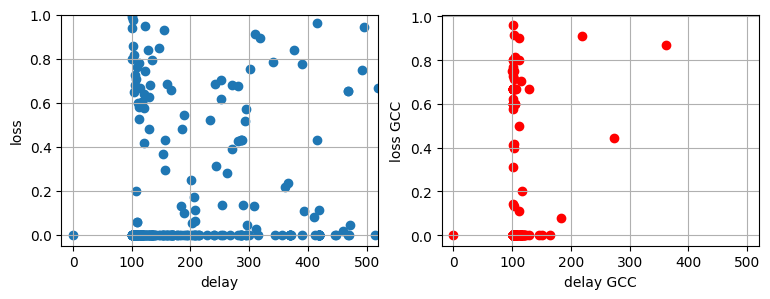

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3))

ax1.scatter(delay_4G, loss_ratio_4G)
ax1.set_xlabel("delay")
ax1.set_ylabel("loss")
ax1.grid()
ax1.set_xlim(-20, 520)
ax1.set_ylim(-0.05, 1)

ax2.scatter(delay_4G_gcc, loss_ratio_4G_gcc, color="r")
ax2.set_xlabel("delay GCC")
ax2.set_ylabel("loss GCC")
ax2.grid()
ax2.set_xlim(-20, 520)
ax1.set_ylim(-0.05, 1)

Text(0.5, 1.0, 'Losses vs. delay RL')

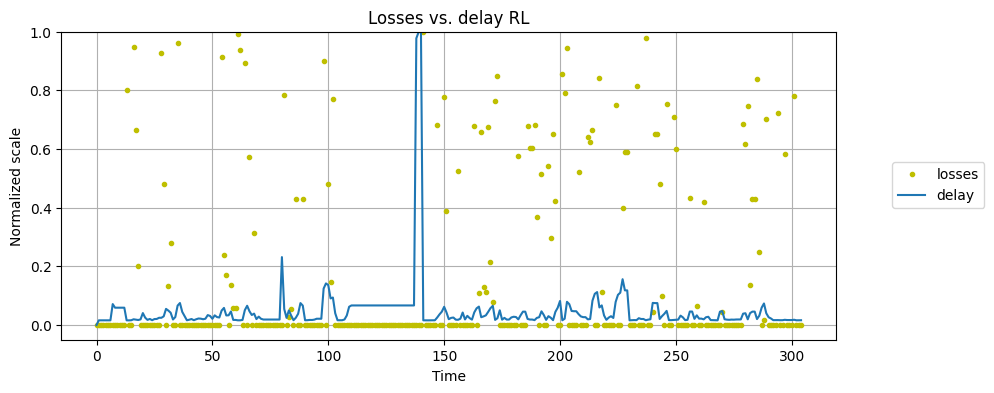

In [8]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(loss_ratio_4G.min(), loss_ratio_4G.max()))

x = delay_4G.values.reshape(-1,1) #returns a numpy array
x_scaled = min_max_scaler.fit_transform(x)

plt.figure(figsize=(10,4))
plt.grid()
plt.ylim(-0.05, 1)
plt.ylabel("Normalized scale")
plt.xlabel("Time")
plt.plot(loss_ratio_4G.values, 'yo', markersize=3, label="losses")
plt.plot(x_scaled, label="delay")
plt.legend(bbox_to_anchor=(1.2,0.6))
plt.title("Losses vs. delay RL")

Text(0.5, 1.0, 'Losses vs. delay GCC')

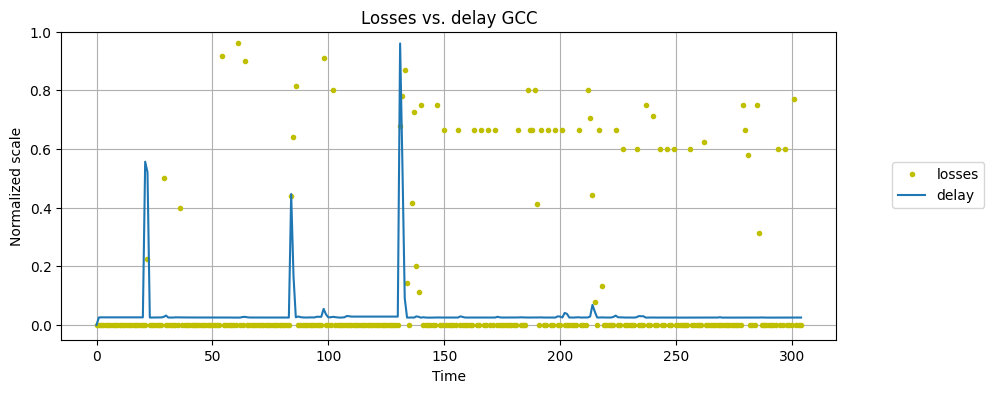

In [9]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(loss_ratio_4G_gcc.min(), loss_ratio_4G_gcc.max()))

x = delay_4G_gcc.values.reshape(-1,1) #returns a numpy array
x_scaled = min_max_scaler.fit_transform(x)

plt.figure(figsize=(10,4))
plt.grid()
plt.ylim(-0.05, 1)
plt.ylabel("Normalized scale")
plt.xlabel("Time")
plt.plot(loss_ratio_4G_gcc.values, 'yo', markersize=3, label="losses")
plt.plot(x_scaled, label="delay")
plt.legend(bbox_to_anchor=(1.2,0.6))
plt.title("Losses vs. delay GCC")

# Check order of traces by average reward

In [10]:
df = pd.DataFrame(result_qoe)
df

,trace,qoe_rr,qoe_rr_gcc,qoe_delay,qoe_delay_gcc,qoe_losses,qoe_losses_gcc,qoe,qoe_gcc,avg_reward
0,WIRED_900kbps,75.881936,92.940000,83.785694,38.369154,100.00,100.00,86.469321,77.025948,0.442057
1,WIRED_200kbps,85.604520,93.782178,98.059935,82.472933,100.00,100.00,94.460263,91.992952,0.275064
2,WIRED_35mbps,20.522474,8.657727,66.769298,66.513467,99.13,99.47,62.078382,58.155137,-0.007698
3,4G_700kbps,73.666340,59.770873,86.667891,89.756545,100.00,99.84,86.691299,83.039287,0.173891
4,4G_3mbps,81.912500,12.322388,91.065255,96.791309,83.51,87.38,85.409009,65.432837,-0.448433
5,4G_500kbps,69.980806,78.806782,91.517958,76.254679,99.78,99.83,87.006775,84.877641,0.066000
6,5G_12mbps,55.947957,4.189749,72.315734,85.380504,94.09,99.82,74.043047,63.068381,-0.091321
7,5G_13mbps,40.538688,5.214884,61.544043,55.831855,91.14,99.99,64.344351,53.623630,-0.142135
8,trace_300k,81.880000,99.213333,79.828851,10.488488,100.00,100.00,87.149047,69.830706,0.503375


In [11]:
df[["trace", "avg_reward"]].set_index("trace").sort_values(by="avg_reward", ascending=False).index

Index(['trace_300k', 'WIRED_900kbps', 'WIRED_200kbps', '4G_700kbps',
       '4G_500kbps', 'WIRED_35mbps', '5G_12mbps', '5G_13mbps', '4G_3mbps'],
      dtype='object', name='trace')

# Check order of traces by gap_to_baseline

In [12]:
dff = df[["trace", "qoe", "qoe_gcc"]].set_index("trace")
(dff["qoe"] - dff["qoe_gcc"]).sort_values(ascending=False)

trace
4G_3mbps         19.976172
trace_300k       17.318341
5G_12mbps        10.974666
5G_13mbps        10.720721
WIRED_900kbps     9.443373
WIRED_35mbps      3.923245
4G_700kbps        3.652012
WIRED_200kbps     2.467311
4G_500kbps        2.129134
dtype: float64

## Plot QoE results

In [13]:
df = pd.DataFrame(result_qoe)
df

,trace,qoe_rr,qoe_rr_gcc,qoe_delay,qoe_delay_gcc,qoe_losses,qoe_losses_gcc,qoe,qoe_gcc,avg_reward
0,WIRED_900kbps,75.881936,92.940000,83.785694,38.369154,100.00,100.00,86.469321,77.025948,0.442057
1,WIRED_200kbps,85.604520,93.782178,98.059935,82.472933,100.00,100.00,94.460263,91.992952,0.275064
2,WIRED_35mbps,20.522474,8.657727,66.769298,66.513467,99.13,99.47,62.078382,58.155137,-0.007698
3,4G_700kbps,73.666340,59.770873,86.667891,89.756545,100.00,99.84,86.691299,83.039287,0.173891
4,4G_3mbps,81.912500,12.322388,91.065255,96.791309,83.51,87.38,85.409009,65.432837,-0.448433
5,4G_500kbps,69.980806,78.806782,91.517958,76.254679,99.78,99.83,87.006775,84.877641,0.066000
6,5G_12mbps,55.947957,4.189749,72.315734,85.380504,94.09,99.82,74.043047,63.068381,-0.091321
7,5G_13mbps,40.538688,5.214884,61.544043,55.831855,91.14,99.99,64.344351,53.623630,-0.142135
8,trace_300k,81.880000,99.213333,79.828851,10.488488,100.00,100.00,87.149047,69.830706,0.503375


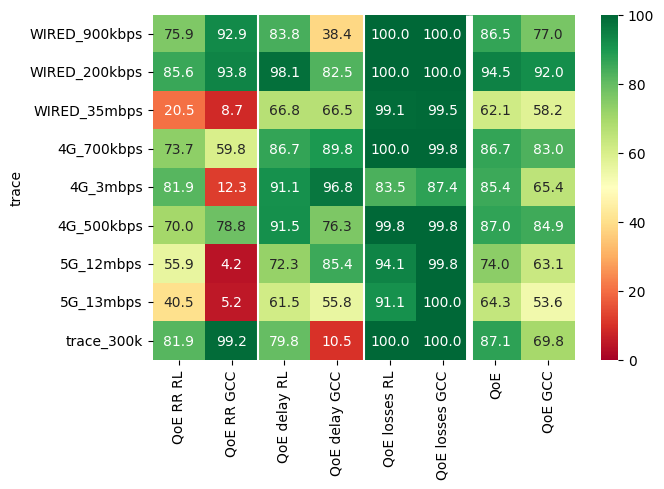

In [14]:
import seaborn as sns
plt.figure(figsize=(7,5))
ax = sns.heatmap(df.drop("avg_reward", axis=1).set_index("trace"), annot=True, fmt=".1f", cmap="RdYlGn",
                 cbar_kws={'ticks': [0, 20, 40, 60, 80, 100]}, vmin=0, vmax=100
                )
plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5], ["QoE RR RL", "QoE RR GCC", "QoE delay RL", "QoE delay GCC", "QoE losses RL", "QoE losses GCC", "QoE", "QoE GCC"])
ax.vlines([2, 4], *ax.get_ylim(), color="white")
ax.vlines([6], *ax.get_ylim(), color="white", lw=5)
plt.tight_layout()
# plt.savefig("plots/heatmap_QoE_best_conf.png")

In [15]:
from matplotlib import rcParams
#IEEE Times New Roman (Nimbus Roman)
rcParams['text.latex.preamble'] = r"\usepackage{mathptmx}"

#Latex in general
rcParams['font.family'] = "serif"
rcParams['font.serif'] = ['Computer Modern']
rcParams['text.usetex'] = True

In [16]:
df_start = df.set_index("trace").drop(["qoe", "qoe_gcc"], axis=1)

In [17]:
import pandas as pd
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0.5, 1))

x = df_start["qoe_losses"].values.reshape(-1, 1) #returns a numpy array
x_scaled = min_max_scaler.fit_transform(x)

x2 = df_start["qoe_losses_gcc"].values.reshape(-1, 1)
x_scaled_gcc = min_max_scaler.fit_transform(x2)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


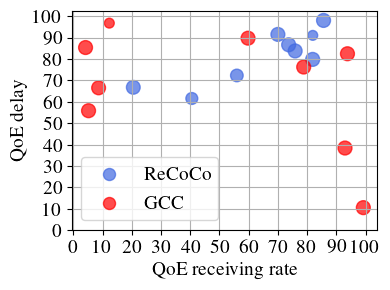

In [18]:
fontsize=14
plt.figure(figsize=(4,3))
plt.scatter(df_start["qoe_rr"], df_start["qoe_delay"], s=x_scaled*100, label="ReCoCo", color="royalblue", alpha=0.7)
# plt.scatter(2.6, 72)
plt.scatter(df_start["qoe_rr_gcc"], df_start["qoe_delay_gcc"], s=x_scaled_gcc*100, label="GCC", color="red", alpha=0.7)
plt.xlabel("QoE receiving rate", fontsize=fontsize)
plt.ylabel("QoE delay", fontsize=fontsize)
plt.grid()
plt.xticks(range(0,110,10), range(0,110,10), fontsize=fontsize)
plt.yticks(range(0,110,10), range(0,110,10), fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
# plt.savefig("plots/scatterplot_QoE_best_conf.pdf")
plt.savefig("plots/scatterplot_QoE_best_conf.png", dpi=500, transparent=True)